In [23]:
import random
import pandas as pd
import jieba
import time
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.externals import joblib
from numpy import * # 要用到delete操作
import numpy as np
from collections import defaultdict,Counter
import math
from gensim import corpora,models
from scipy.sparse import csr_matrix
import pickle as pkl
# 不打印警告信息
import warnings
warnings.filterwarnings('ignore')

C:\Users\zhangyh4\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### 方法一：取出目录中所有的文件

In [8]:

import os

def file_name(file_dir):
    file = []
    for root,dirs,files in os.walk(file_dir):
        return files
file_list = file_name(r'C:\Users\zhangyh4\Desktop\xietong1012\model')

In [9]:
len(file_list)

7459

### 方法二：取出目录中的指定文件

In [16]:
import os

file_dir = r'C:\Users\zhangyh4\Desktop\xietong1012\model'
bayes_list = []
svm_list = []
xgboost_list = []
for root,dirs,files in os.walk(file_dir):
    for file in files:
        if os.path.splitext(file)[0] == 'bayes':
            bayes_list.append(os.path.join(root,file))
        elif os.path.splitext(file)[0] == 'svm':
            svm_list.append(os.path.join(root,file))
        elif os.path.splitext(file)[0] == 'xgboost':
            xgboost_list.append(os.path.join(root,file))


In [19]:
bayes_list[:1]

['C:\\Users\\zhangyh4\\Desktop\\xietong1012\\model\\bayes.joblib_161006']

### 测试模型效果并打印

In [24]:
sum_data = pd.read_csv(r"testdata.txt",names=['label','lines'],sep='\t',encoding='utf-8')

In [25]:
sum_data.head()

,label,lines
0,1,尚贤 哆啦A梦最爱吃的的铜锣烧428g 金黄饼皮，浓浓馅料，松软下的红豆爆浆，...
1,1,秋冬韩版长款加厚百搭两用针织围脖原 价：【35.0】元券后【25元】包邮秒杀优质的面料...
2,1,还有价值8300元的神秘大礼包 啊！ 转发此条说说积攒38个，晚会当天可换取精品...
3,1,三缺一电玩 首次注册送20W!oiavf捕鱼棋牌老虎机样样有真正能赢钱的平台！满130万=1...
4,1,【彩缤儿】2件装无钢圈无痕运动内衣美背式运动文胸2件装，亲肤舒适，无钢圈设计，交叉肩带，...


In [26]:
import jieba
from gensim import corpora
from gensim import models
import time
# start = time.clock()

# 去掉文本中的空格
def process(our_data):
    m1 = map(lambda s:s.replace(' ',''),our_data)
    return list(m1)

# 让文本只保留汉字
def is_chinese(uchar):
    if uchar >= u'\u4e00' and uchar <= u'\u9fa5':
        return True
    else:
        return False
    
def format_str(content):
    content_str = ''
    for i in content:
        if is_chinese(i):
            content_str = content_str +ｉ
    return content_str 

# 对文本进行jieba分词
def fenci(datas):
    cut_words=map(lambda s:list(jieba.cut(s)),datas)
    return list(cut_words)

# 读取停用词表
stopwords=pd.read_csv('stopwords.txt',index_col=False,sep="\n",quoting=3,names=['stopword'],encoding='utf-8')

# 去掉文本中的停用词
def drop_stopwords(contents,stopwords):
    contents_clean = []
    for line in contents:
        line_clean = []
        for word in line:
            if word in stopwords:
                continue
            line_clean.append(word)
        contents_clean.append(line_clean)
    return contents_clean

train_data = process(sum_data.lines.values)

chinese_list = []
for line in train_data:
    chinese_list.append(format_str(line))
    
df_content=pd.DataFrame({'content_S':chinese_list,'label':sum_data['label']})
content_s = fenci(df_content.content_S.values)
data_content=pd.DataFrame({'content':content_s})

contents = data_content.content.values.tolist()
stopwords = stopwords.stopword.values.tolist()
contents_clean = drop_stopwords(contents,stopwords)

df_data=pd.DataFrame({'contents_clean':contents_clean,'label':sum_data["label"]})
word_list = list(df_data.contents_clean.values)

# 将文本处理成tfidf可训练的格式
words = []
for line_index in range(len(word_list)):
    words.append(' '.join(word_list[line_index]))

word_list = []
for i in range(len(words)):
    word_list.append(words[i].split(' '))


dictionary = corpora.Dictionary(word_list)
new_corpus = [dictionary.doc2bow(text) for text in word_list]
tfidf = models.TfidfModel(new_corpus)

tfidf_vec = []
for i in range(len(words)):
    string = words[i]
    string_bow = dictionary.doc2bow(string.split())
    string_tfidf = tfidf[string_bow]
    tfidf_vec.append(string_tfidf)

lsi_model = models.LsiModel(corpus = tfidf_vec,id2word = dictionary,num_topics=30)

lsi_vec = []
for i in range(len(words)):
    string = words[i]
    string_bow = dictionary.doc2bow(string.split())
    string_lsi = lsi_model[string_bow]
    lsi_vec.append(string_lsi)


data = []
rows = []
cols = []
line_count = 0
for line in lsi_vec:
    for elem in line:
        rows.append(line_count)
        cols.append(elem[0])
        data.append(elem[1])
    line_count += 1
lsi_sparse_matrix = csr_matrix((data,(rows,cols))) # 稀疏向量
lsi_matrix = lsi_sparse_matrix.toarray() # 密集向量


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zhangyh4\AppData\Local\Temp\jieba.cache
Loading model cost 0.754 seconds.
Prefix dict has been built succesfully.


In [27]:
x_test = list(lsi_matrix)
len(x_test)

5000

In [28]:
from sklearn import metrics
from sklearn.metrics import precision_score

### svm

In [71]:
len(svm_list)

4336

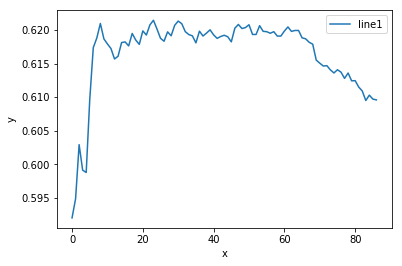

In [72]:
svm_index = []
for i in range(4336):
    if i % 50 == 0:
        svm_index.append(i)

new_svm_list = []
for i in svm_index:
    new_svm_list.append(svm_list[i])
    
y_True = list(sum_data.label.values)
def pred_func(file_dir,y_true):
    model = joblib.load(file_dir)
    y_pred = model.predict(x_test)
    y_pred = list(y_pred)
    pred_score = precision_score(y_true,y_pred,average='weighted')
    return pred_score

svm_score = []
for i in range(len(new_svm_list)):
    svm_score.append(pred_func(new_svm_list[i],y_True))
    
x = svm_score
y = range(len(x))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(y,x)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['line1'])
plt.show()

In [74]:
max(svm_score)

0.621426771534017

### bayes

In [75]:
len(bayes_list)

2084

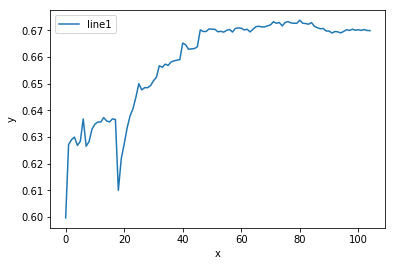

In [76]:
bayes_index = []
for i in range(2084):
    if i % 20 == 0:
        bayes_index.append(i)
        
new_bayes_list = []
for i in bayes_index:
    new_bayes_list.append(bayes_list[i])
    
y_True = list(sum_data.label.values)
def pred_func(file_dir,y_true):
    model = joblib.load(file_dir)
    y_pred = model.predict(x_test)
    y_pred = list(y_pred)
    pred_score = precision_score(y_true,y_pred,average='weighted')
    return pred_score

bayes_score = []
for i in range(len(new_bayes_list)):
    bayes_score.append(pred_func(new_bayes_list[i],y_True))
    
x = bayes_score
y = range(len(x))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(y,x)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['line1'])
plt.show()

In [77]:
max(bayes_score)

0.6737846016893565

### xgboost

In [78]:
len(xgboost_list)

1056

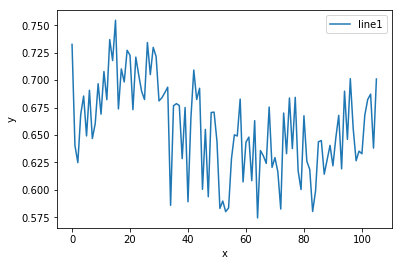

In [79]:
xgboost_index = []
for i in range(len(xgboost_list)):
    if i % 10 == 0:
        xgboost_index.append(i)
        
new_xgboost_list = []
for i in xgboost_index:
    new_xgboost_list.append(xgboost_list[i])
    
y_True = list(sum_data.label.values)
def pred_func(file_dir,y_true):
    model = joblib.load(file_dir)
    y_pred = model.predict(x_test)
    y_pred = list(y_pred)
    pred_score = precision_score(y_true,y_pred,average='weighted')
    return pred_score

xgboost_score = []
for i in range(len(new_xgboost_list)):
    xgboost_score.append(pred_func(new_xgboost_list[i],y_True))

x = xgboost_score
y = range(len(x))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(y,x)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['line1'])
plt.show()

In [80]:
max(xgboost_score)

0.7545448248656177

In [13]:

file = r'C:\Users\zhangyh4\Desktop\xietong1016\model\xgboost.joblib_161006'
svm_model = joblib.load(file)
y_svm_pred = svm_model.predict(x_test)
y_true = list(sum_data.label.values)
y_pred = list(y_svm_pred)
precision_score(y_true,y_pred,average='weighted')

0.7604906959076174

In [15]:
file = r'C:\Users\zhangyh4\Desktop\xietong1016\model\xgboost.joblib_190944'
svm_model = joblib.load(file)
y_svm_pred = svm_model.predict(x_test)
y_true = list(sum_data.label.values)
y_pred = list(y_svm_pred)
precision_score(y_true,y_pred,average='weighted')

0.6887115928021272